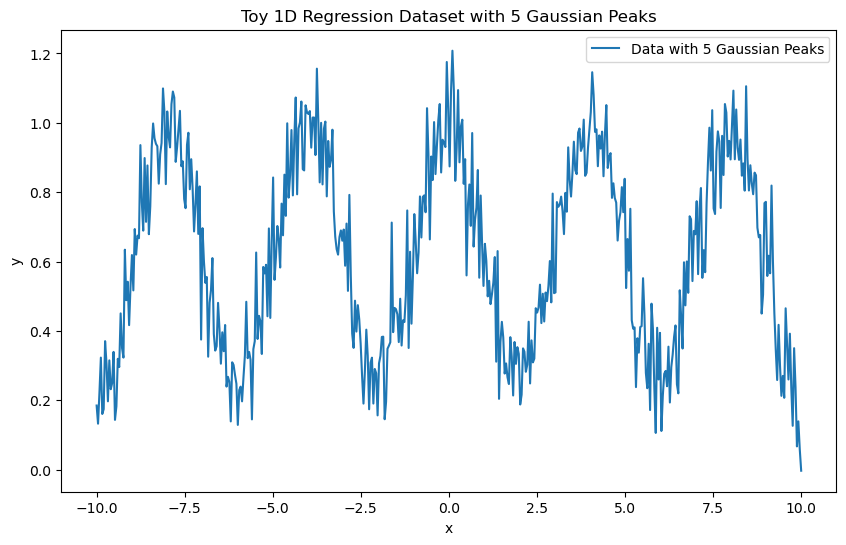

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

def generate_gaussian_peaks(num_peaks=5, points_per_peak=100, noise_std=0.1, seed=42):
    np.random.seed(seed)
    x = np.linspace(-10, 10, num_peaks * points_per_peak)
    y = np.zeros_like(x)
    
    peak_centers = np.linspace(-8, 8, num_peaks)
    peak_width = 1.0
    amplitude = 1.0
    
    for center in peak_centers:
        y += amplitude * np.exp(-0.5 * ((x - center) / peak_width) ** 2)
    
    y += np.random.normal(0, noise_std, size=y.shape)
    return x, y, peak_centers

# Generate the data
x, y, peak_centers = generate_gaussian_peaks()

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Data with 5 Gaussian Peaks')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Toy 1D Regression Dataset with 5 Gaussian Peaks')
plt.legend()
plt.show()


In [35]:
def create_mlp(input_dim=1, hidden_dim=50, output_dim=1):
    model = models.Sequential([
        layers.Dense(hidden_dim, activation='tanh', input_shape=(input_dim,)),
        layers.Dense(hidden_dim, activation='tanh'),
        layers.Dense(output_dim)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                  loss=losses.MeanSquaredError())
    return model


In [36]:
class SplineActivation(layers.Layer):
    def __init__(self, num_knots=10, **kwargs):
        super(SplineActivation, self).__init__(**kwargs)
        self.num_knots = num_knots

    def build(self, input_shape):
        # Number of units in the previous layer
        units = input_shape[-1]
        
        # Initialize knot positions uniformly between -10 and 10
        knots_init = np.linspace(-10.0, 10.0, self.num_knots).astype(np.float32)
        self.knots = self.add_weight(
            shape=(self.num_knots,),
            initializer=tf.keras.initializers.Constant(knots_init),
            trainable=False,
            name='knots'
        )
        
        # Initialize coefficients for linear interpolation with random normal values
        # **Correction:** Per-unit coefficients with shape (units, num_knots)
        self.coeffs = self.add_weight(
            shape=(units, self.num_knots,),
            initializer=tf.keras.initializers.RandomNormal(),
            trainable=True,
            name='coeffs'
        )

    def call(self, inputs):
        # Expand dimensions for broadcasting: (batch, units) -> (batch, units, 1)
        x = tf.expand_dims(inputs, axis=-1)  # Shape: (batch, units, 1)
        
        # Reshape knots to (1, 1, num_knots) for broadcasting
        knots = tf.reshape(self.knots, (1, 1, self.num_knots))  # Shape: (1, 1, num_knots)
        
        # Reshape coefficients to (1, units, num_knots) for broadcasting
        coeffs = tf.reshape(self.coeffs, (1, -1, self.num_knots))  # Shape: (1, units, num_knots)
        
        # Compute indices of knots for each input
        indices = tf.searchsorted(knots, x, side='right') - 1  # Shape: (batch, units, 1)
        indices = tf.clip_by_value(indices, 0, self.num_knots - 2)
        
        # Gather knots and coefficients for interpolation
        x0 = tf.gather(knots, indices, batch_dims=2)  # Shape: (batch, units, 1)
        x1 = tf.gather(knots, indices + 1, batch_dims=2)  # Shape: (batch, units, 1)
        y0 = tf.gather(coeffs, indices, batch_dims=2)  # Shape: (batch, units, 1)
        y1 = tf.gather(coeffs, indices + 1, batch_dims=2)  # Shape: (batch, units, 1)
        
        # Compute interpolation factor
        t = (x - x0) / (x1 - x0 + 1e-6)  # Shape: (batch, units, 1)
        
        # Linear interpolation
        y = y0 + t * (y1 - y0)  # Shape: (batch, units, 1)
        
        # Squeeze the last dimension to match (batch, units)
        y = tf.squeeze(y, axis=-1)  # Shape: (batch, units)
        
        return y

def create_kan(input_dim=1, hidden_dim=50, output_dim=1, num_knots=10):
    model = models.Sequential([
        layers.Dense(hidden_dim, input_shape=(input_dim,)),
        SplineActivation(num_knots=num_knots),
        layers.Dense(output_dim)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                  loss=losses.MeanSquaredError())
    return model


In [32]:
class SplineActivation(layers.Layer):
    def __init__(self, num_knots=10, **kwargs):
        super(SplineActivation, self).__init__(**kwargs)
        self.num_knots = num_knots

    def build(self, input_shape):
        # Initialize knot positions uniformly between -10 and 10 using a constant initializer
        knots_init = np.linspace(-10.0, 10.0, self.num_knots).astype(np.float32)
        self.knots = self.add_weight(
            shape=(self.num_knots,),
            initializer=tf.keras.initializers.Constant(knots_init),
            trainable=False,
            name='knots'
        )
        
        # Initialize coefficients for linear interpolation with random normal values
        self.coeffs = self.add_weight(
            shape=(self.num_knots,),
            initializer=tf.keras.initializers.RandomNormal(),
            trainable=True,
            name='coeffs'
        )

    def call(self, inputs):
        # Expand dimensions for broadcasting
        x = tf.expand_dims(inputs, axis=-1)  # Shape: (batch, units, 1)
        knots = tf.reshape(self.knots, (1, 1, -1))  # Shape: (1, 1, num_knots)
        coeffs = tf.reshape(self.coeffs, (1, 1, -1))  # Shape: (1, 1, num_knots)
        
        # Compute indices of knots
        indices = tf.searchsorted(knots, x, side='right') - 1
        indices = tf.clip_by_value(indices, 0, self.num_knots - 2)
        
        # Gather knots and coefficients for interpolation
        x0 = tf.gather(knots, indices, batch_dims=2)
        x1 = tf.gather(knots, indices + 1, batch_dims=2)
        y0 = tf.gather(coeffs, indices, batch_dims=2)
        y1 = tf.gather(coeffs, indices + 1, batch_dims=2)
        
        # Compute interpolation factor
        t = (x - x0) / (x1 - x0 + 1e-6)
        y = y0 + t * (y1 - y0)
        return y

def create_kan(input_dim=1, hidden_dim=50, output_dim=1, num_knots=10):
    model = models.Sequential([
        layers.Dense(hidden_dim, input_shape=(input_dim,)),
        SplineActivation(num_knots=num_knots),
        layers.Dense(output_dim)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                  loss=losses.MeanSquaredError())
    return model


In [37]:
def get_data_loader(x, y, center, width=1.5, batch_size=32):
    # Select data around the current peak
    mask = (x >= center - width) & (x <= center + width)
    x_peak = x[mask]
    y_peak = y[mask]
    
    # Convert to tensors
    x_tensor = x_peak.reshape(-1, 1).astype(np.float32)
    y_tensor = y_peak.reshape(-1, 1).astype(np.float32)
    
    return x_tensor, y_tensor

def train_model(model, x_train, y_train, epochs=100, batch_size=32):
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

def evaluate_model(model, x):
    y_pred = model.predict(x.reshape(-1, 1), verbose=0).flatten()
    return y_pred

# Initialize models
mlp = create_mlp()
kan = create_kan()

# Store predictions after each phase
mlp_predictions = []
kan_predictions = []

# Convert entire dataset to TensorFlow tensors for evaluation
x_full = x
y_full = y

# Training phases
for i, center in enumerate(peak_centers):
    print(f"--- Phase {i+1}: Training on peak centered at x = {center:.2f} ---")
    
    # Get data for the current phase
    x_train, y_train = get_data_loader(x, y, center)
    
    # Train MLP
    train_model(mlp, x_train, y_train)
    
    # Train KAN
    train_model(kan, x_train, y_train)
    
    # Evaluate on the entire dataset
    mlp_pred = evaluate_model(mlp, x_full)
    kan_pred = evaluate_model(kan, x_full)
    
    mlp_predictions.append(mlp_pred)
    kan_predictions.append(kan_pred)


--- Phase 1: Training on peak centered at x = -8.00 ---


InvalidArgumentError: Graph execution error:

Detected at node sequential_7_1/spline_activation_9_1/UpperBound defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/anaconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/anaconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/opt/anaconda3/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/opt/anaconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/fw/zk___1450g3310mqlzmmsf040000gn/T/ipykernel_64441/2724937259.py", line 43, in <module>

  File "/var/folders/fw/zk___1450g3310mqlzmmsf040000gn/T/ipykernel_64441/2724937259.py", line 14, in train_model

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/sequential.py", line 213, in call

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py", line 182, in call

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py", line 584, in call

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/var/folders/fw/zk___1450g3310mqlzmmsf040000gn/T/ipykernel_64441/1070057612.py", line 39, in call

Leading dim_size of both tensors must match.
	 [[{{node sequential_7_1/spline_activation_9_1/UpperBound}}]] [Op:__inference_one_step_on_iterator_93910]

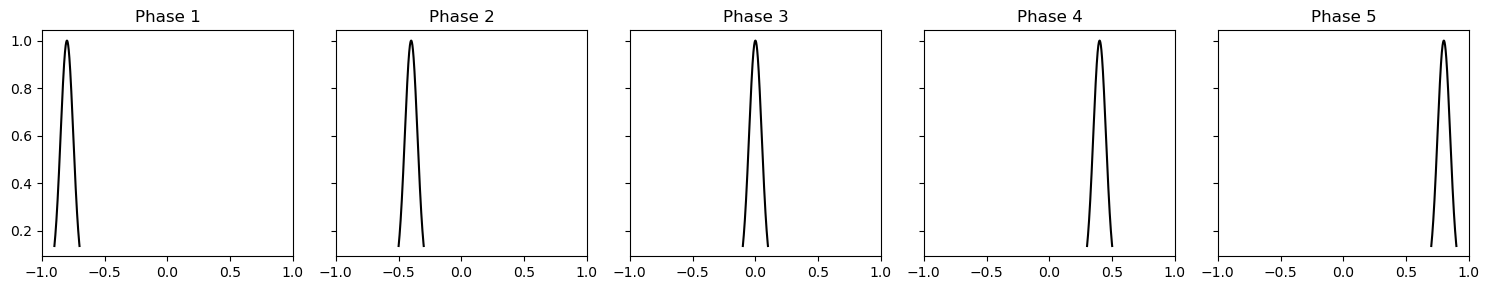

In [6]:
def generate_gaussian_data(centers, width=0.05, n_samples=500):
    """
    Generates 1D regression data with Gaussian peaks centered at given locations.
    Each phase contains data near one Gaussian peak.
    """
    X, y = [], []
    for center in centers:
        x_phase = np.linspace(center - 0.1, center + 0.1, n_samples)
        y_phase = np.exp(-((x_phase - center) ** 2) / (2 * width ** 2))
        X.append(x_phase)
        y.append(y_phase)
    return X, y

# Define Gaussian peak centers for 5 phases
centers = [-0.8, -0.4, 0.0, 0.4, 0.8]
X_phases, y_phases = generate_gaussian_data(centers)

# Visualize the updated dataset
fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
for i, (X, y) in enumerate(zip(X_phases, y_phases)):
    axs[i].plot(X, y, color="black")
    axs[i].set_title(f"Phase {i+1}")
    axs[i].set_xlim(-1, 1)
plt.tight_layout()
plt.show()


In [7]:
from tensorflow.keras import layers, models

class LocalKAN(models.Model):
    def __init__(self, num_local_units=10):
        super().__init__()
        self.hidden = layers.Dense(num_local_units, activation='relu')  # Localized behavior
        self.output_layer = layers.Dense(1)

    def call(self, inputs):
        x = self.hidden(inputs)
        return self.output_layer(x)


In [8]:
def train_local_kan(X_phases, y_phases, epochs=300):
    kan_model = LocalKAN(num_local_units=50)
    kan_model.compile(optimizer='adam', loss='mse')
    kan_predictions = []
    X_test = np.linspace(-1, 1, 500).reshape(-1, 1)

    for i, (X_phase, y_phase) in enumerate(zip(X_phases, y_phases)):
        print(f"Training KAN on Phase {i+1}")
        X_phase = np.array(X_phase).reshape(-1, 1)
        y_phase = np.array(y_phase).reshape(-1, 1)

        # Train on current phase
        kan_model.fit(X_phase, y_phase, epochs=epochs, verbose=0)

        # Store predictions
        y_pred = kan_model.predict(X_test)
        kan_predictions.append(y_pred)

    return kan_predictions, X_test

# Train KAN
kan_predictions, X_test = train_local_kan(X_phases, y_phases)


Training KAN on Phase 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Training KAN on Phase 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
Training KAN on Phase 3
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
Training KAN on Phase 4
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
Training KAN on Phase 5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


In [10]:
def train_mlp(X_phases, y_phases, epochs=300):
    from sklearn.neural_network import MLPRegressor

    mlp_model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=epochs)
    mlp_predictions = []

    X_test = np.linspace(-1, 1, 500).reshape(-1, 1)
    for i, (X_phase, y_phase) in enumerate(zip(X_phases, y_phases)):
        print(f"Training MLP on Phase {i+1}")
        X_phase = np.array(X_phase).reshape(-1, 1)
        y_phase = np.array(y_phase).reshape(-1,)

        mlp_model.fit(X_phase, y_phase)

        y_pred = mlp_model.predict(X_test)
        mlp_predictions.append(y_pred)

    return mlp_predictions, X_test

# Train MLP
mlp_predictions, X_test = train_mlp(X_phases, y_phases)


Training MLP on Phase 1
Training MLP on Phase 2
Training MLP on Phase 3
Training MLP on Phase 4
Training MLP on Phase 5


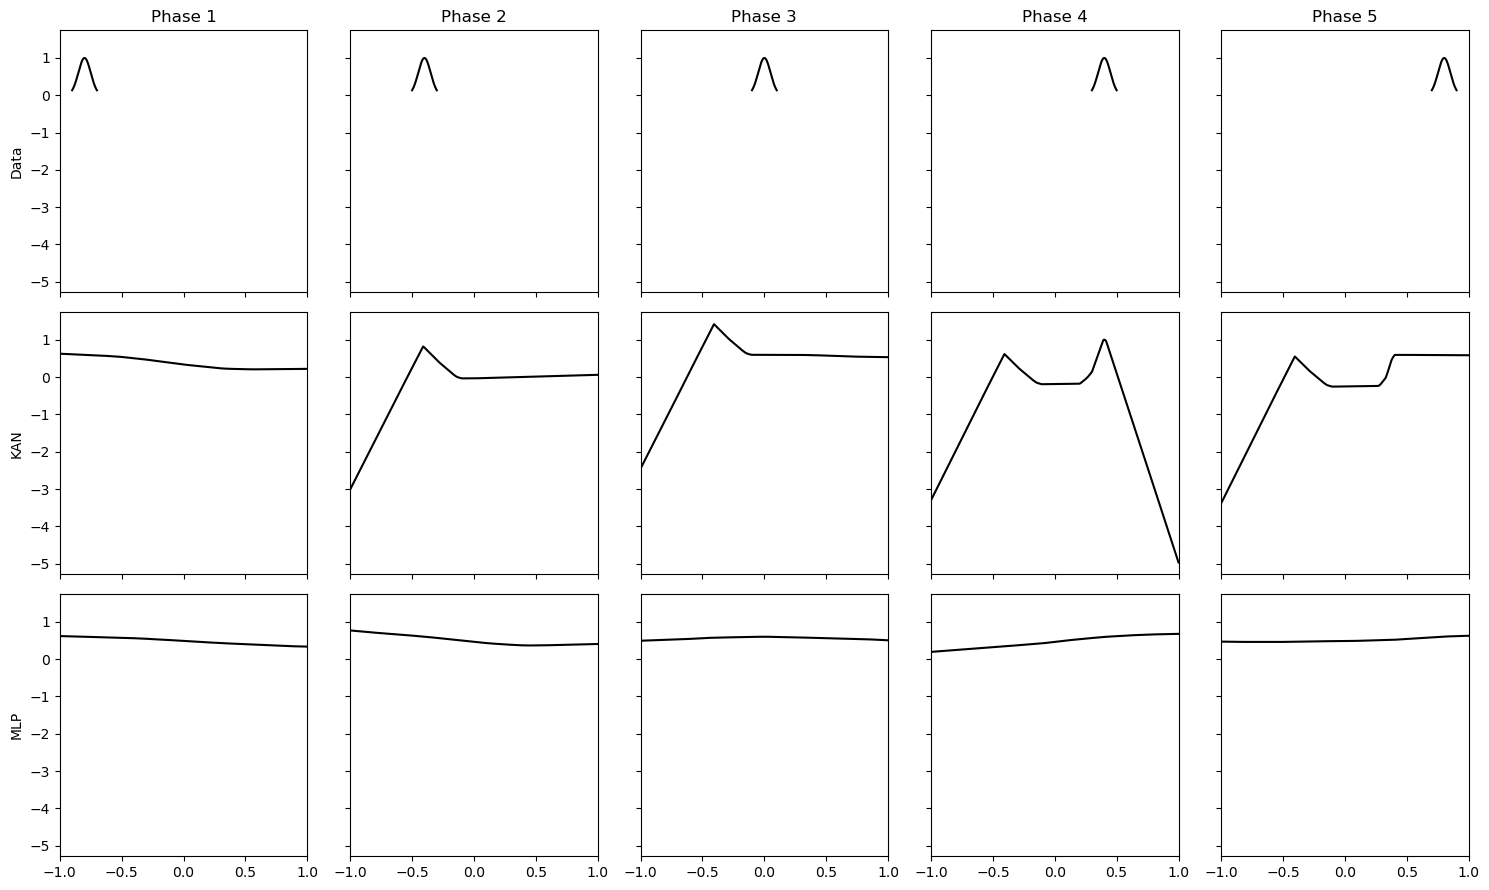

In [11]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9), sharey=True, sharex=True)

# Row 1: Data
for i, (X, y) in enumerate(zip(X_phases, y_phases)):
    axs[0, i].plot(X, y, color="black")
    axs[0, i].set_title(f"Phase {i+1}")
    axs[0, i].set_xlim(-1, 1)

# Row 2: KAN Predictions
for i, y_pred in enumerate(kan_predictions):
    axs[1, i].plot(X_test, y_pred, color="black")

# Row 3: MLP Predictions
for i, y_pred in enumerate(mlp_predictions):
    axs[2, i].plot(X_test, y_pred, color="black")

# Row Labels
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("KAN")
axs[2, 0].set_ylabel("MLP")

plt.tight_layout()
plt.show()


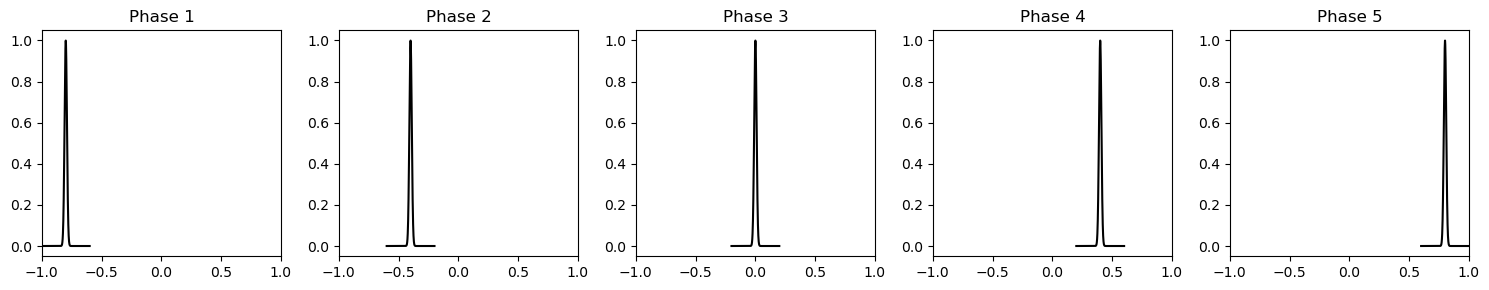

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def generate_localized_gaussian(center, width=0.01, n_samples=500):
    """Generate a localized Gaussian dataset around a specific center."""
    x = np.linspace(center - 0.2, center + 0.2, n_samples)  # Narrow range around center
    y = np.exp(-((x - center) ** 2) / (2 * width ** 2))
    return x, y

# Generate 5 phases of Gaussian data
centers = [-0.8, -0.4, 0.0, 0.4, 0.8]
X_phases, y_phases = [], []

for center in centers:
    X, y = generate_localized_gaussian(center)
    X_phases.append(X)
    y_phases.append(y)

# Visualize data
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, (X, y) in enumerate(zip(X_phases, y_phases)):
    axs[i].plot(X, y, color="black")
    axs[i].set_title(f"Phase {i+1}")
    axs[i].set_xlim(-1, 1)
plt.tight_layout()
plt.show()


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

class SplineActivation(layers.Layer):
    """Custom Spline Activation Layer."""
    def __init__(self, num_knots=10):
        super().__init__()
        self.knots = tf.Variable(tf.linspace(-1.0, 1.0, num_knots), trainable=False)
        self.coefficients = tf.Variable(tf.random.uniform((num_knots, 1)), trainable=True)

    def call(self, inputs):
        # Compute piecewise spline activation
        spline = tf.zeros_like(inputs)
        for i in range(len(self.knots) - 1):
            left = self.knots[i]
            right = self.knots[i + 1]
            mask = tf.logical_and(inputs >= left, inputs < right)
            spline += tf.where(mask, self.coefficients[i] * (inputs - left), 0.0)
        return spline

class SplineKAN(models.Model):
    def __init__(self, num_knots=20):
        super().__init__()
        self.spline = SplineActivation(num_knots=num_knots)
        self.dense = layers.Dense(1)

    def call(self, inputs):
        x = self.spline(inputs)
        return self.dense(x)


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

class SplineActivation(tf.keras.layers.Layer):
    """Custom trainable piecewise-linear spline activation."""
    def __init__(self, num_knots=10):
        super(SplineActivation, self).__init__()
        # Initialize spline knots (locations) and values
        self.num_knots = num_knots
        self.knots = tf.Variable(tf.linspace(-1.0, 1.0, num_knots), trainable=False)  # Fixed locations
        self.values = tf.Variable(tf.random.uniform((num_knots, 1)), trainable=True)  # Trainable heights

    def call(self, inputs):
        # Compute piecewise linear spline activation
        batch_size = tf.shape(inputs)[0]
        spline_output = tf.zeros((batch_size, 1), dtype=tf.float32)

        for i in range(self.num_knots - 1):
            left = self.knots[i]
            right = self.knots[i + 1]
            slope = (self.values[i + 1] - self.values[i]) / (right - left)

            # Linear interpolation between the two knots
            mask = tf.logical_and(inputs >= left, inputs < right)
            linear_piece = self.values[i] + slope * (inputs - left)
            spline_output += tf.where(mask, linear_piece, 0.0)

        return spline_output


In [19]:
class SplineKAN(tf.keras.Model):
    """KAN model with Spline Activation Layers."""
    def __init__(self, input_dim=1, num_knots=10, hidden_units=10):
        super(SplineKAN, self).__init__()
        self.input_dim = input_dim  # Save input dimension
        self.spline_layers = [SplineActivation(num_knots) for _ in range(input_dim)]
        self.output_layer = layers.Dense(1)

    def call(self, inputs):
        # Split inputs along the feature dimension
        x = tf.split(inputs, num_or_size_splits=self.input_dim, axis=1)
        inner_outputs = [spline_layer(x_i) for x_i, spline_layer in zip(x, self.spline_layers)]
        combined = tf.add_n(inner_outputs)  # Sum outputs
        return self.output_layer(combined)


In [20]:
# Generate multiplication data
def generate_multiplication_data(n_samples=1000):
    x = np.random.uniform(-1, 1, size=(n_samples, 2))
    y = x[:, 0] * x[:, 1]
    return x, y

X_train, y_train = generate_multiplication_data()
X_train, y_train = X_train.astype(np.float32), y_train.astype(np.float32).reshape(-1, 1)

# Instantiate and train SplineKAN
spline_kan = SplineKAN(input_dim=2, num_knots=20, hidden_units=2)
spline_kan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

history = spline_kan.fit(X_train, y_train, epochs=500, verbose=1)

# Test the model
X_test = np.array([[0.5, 0.4], [-0.2, 0.3]], dtype=np.float32)
y_pred = spline_kan.predict(X_test)
print("Predictions:", y_pred)


Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5817
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1445
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1289
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1230
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 0.1281
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1081
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1260
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 0.1235
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1139
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 0.1143
Epoch 11/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1119 
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1171
Epoch 13/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1034
Epoch 14/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1110
Epoch 15/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0

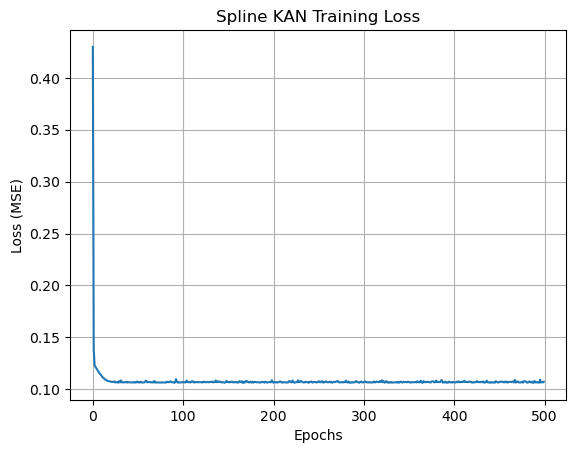

In [21]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Spline KAN Training Loss')
plt.grid(True)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (2, 2) and (500, 1)

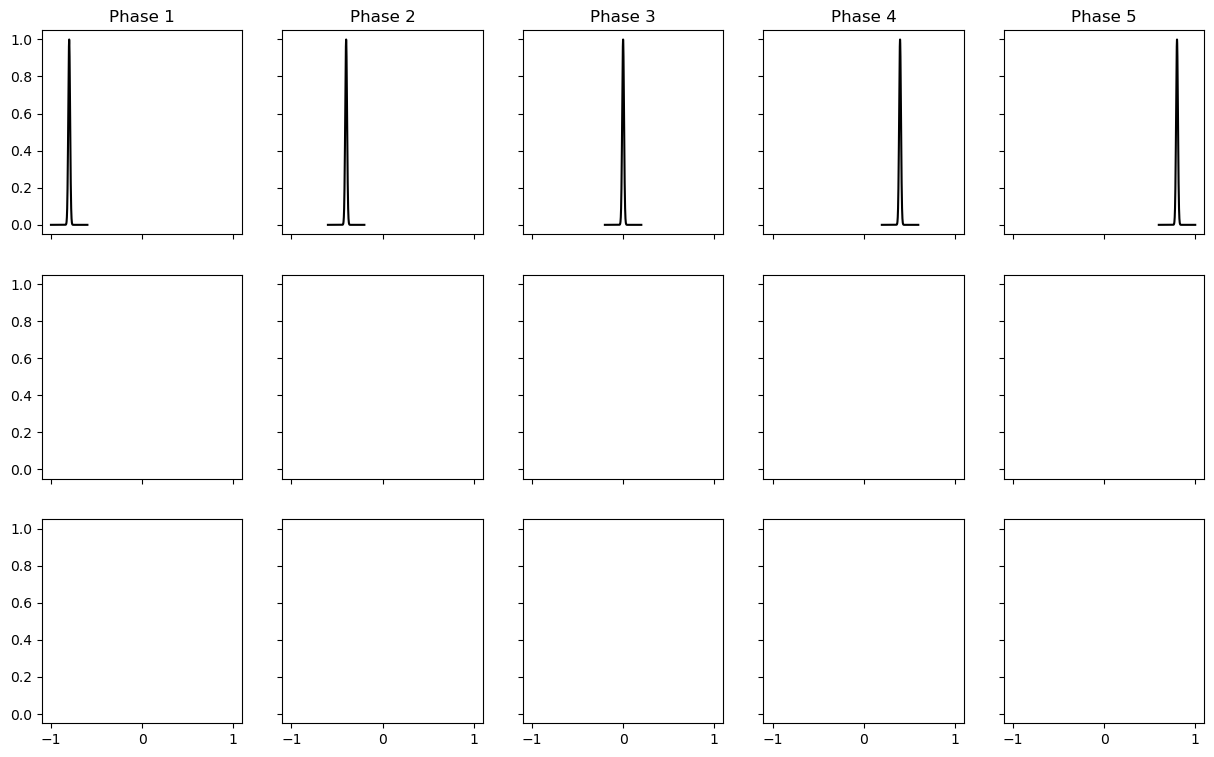

In [23]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9), sharex=True, sharey=True)

# Row 1: Data
for i, (X, y) in enumerate(zip(X_phases, y_phases)):
    axs[0, i].plot(X, y, color="black")
    axs[0, i].set_title(f"Phase {i+1}")

# Row 2: KAN Predictions
for i, y_pred in enumerate(kan_predictions):
    axs[1, i].plot(X_test, y_pred, color="black")

# Row 3: MLP Predictions
for i, y_pred in enumerate(mlp_predictions):
    axs[2, i].plot(X_test, y_pred, color="black")

# Labels
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("KAN")
axs[2, 0].set_ylabel("MLP")

plt.tight_layout()
plt.show()
